In [1]:
from collections import OrderedDict
from itertools import chain
from typing import List, Tuple

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline

# Project 5: Graph Neural Networks (80 pt)

Given the citation network `Cora ML` we are going to perform semi-supervised node classification (*transductive learning*), i.e. predict the category for each node given a few labels. Each node represents one publication and each edge a citation. The features represent the bag of words of the respective abstract after stemming and stop word removal. These papers are classified into one of the following seven classes:
- Case Based
- Genetic Algorithms
- Neural Networks
- Probabilistic Methods
- Reinforcement Learning
- Rule Learning
- Theory

## General remarks

Do not add or modify any code outside of the following comment blocks, or where otherwise explicitly stated.

``` python
##########################################################
# YOUR CODE HERE
...
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Below we list the allowed packages / no additional `import` statements
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

*For scalability reasons, please do not transform sparse matrices to dense (e.g. using `.to_dense()`)*

### You are allowed to use the following methods/packages:

In [3]:
import torch
from torch import nn
from torch import sparse as sp
from torch.nn import functional as F

## Reproducibility
For better reproducibility than in the last task - [*still, it might not be perfect*](https://pytorch.org/docs/stable/notes/randomness.html) :-)

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Check if a GPU is available (or overwrite it with `cpu`)
You are allowed to edit this line if it better fits you needs (only to change the value `use_cuda` - *this will affect the results*):

In [5]:
use_cuda = torch.cuda.is_available()
#use_cuda = False

## Load data

* `N` = number of publications (nodes in the graph)
* `D` = number of features (bag of words one hot representation)
<!--* `C` = number of categories-->
* The graph is stored as a _sparse torch tensor_ `A` (shape `[N, N]`).
* The (binary) Features are stored in a _feature tensor_ `X` (shape `[N, D]`).
* The labels are stored in a _vector_ `y` (shape `[N]`).

In [6]:
X = torch.load('./X.pt')
N, D = X.shape

A_indices = torch.load('./A_indices.pt')
A = torch.sparse.FloatTensor(A_indices, torch.ones_like(A_indices[0]).float(), (N, N)).coalesce()
del A_indices

labels = torch.load('./labels.pt')
C = labels.max().item() + 1

if use_cuda:
    A, X, labels = A.cuda(), X.cuda(), labels.cuda()

A, X, labels, N, D, C

(tensor(indices=tensor([[   0,    0,    0,  ..., 2808, 2809, 2809],
                        [   0, 1579, 1581,  ..., 2808, 1399, 2809]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        device='cuda:0', size=(2810, 2810), nnz=18772, layout=torch.sparse_coo),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 tensor([0, 1, 1,  ..., 4, 6, 3], device='cuda:0'),
 2810,
 2879,
 7)

## 1 - Graph Convolutional Network (35 pt) 

For the graph convolutional layer we are going to use the following update scheme:

$$𝐻^{(𝑙+1)}=\sigma\left(𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}} 𝐻^{(𝑙)} 𝑊{(𝑙)}\right)$$

We use the ReLU for the activation function, but in the last layer where we directly output the raw logits (i.e. no activation at all). With $𝐻^{(0)}$ we denote the node features.


### 1.1 - Implementation (25 pt)

In this section your task is to implement a GCN in two steps. First we define the message passing / graph convolution module and then use this building block for a GCN.

#### 1.1.1 - Graph Convolution Layer / Message Passing (5 pt)

We also denote the normalized adjacency matrix as $\hat{A} = 𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}}$. Here you are supposed to implement:

$$Z^{(𝑙+1)}=\hat{A} 𝐻^{(𝑙)} 𝑊{(𝑙)}$$

In [7]:
class GraphConvolution(nn.Module):
    """
    Graph Convolution Layer: as proposed in [Kipf et al. 2017](https://arxiv.org/abs/1609.02907).
    
    Parameters
    ----------
    in_channels: int
        Dimensionality of input channels/features.
    out_channels: int
        Dimensionality of output channels/features.
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self._linear = nn.Linear(in_channels, out_channels, bias=False)

    def forward(self, arguments: Tuple[torch.tensor, torch.sparse.FloatTensor]) -> torch.tensor:
        """
        Forward method.
        
        Parameters
        ----------
        arguments: Tuple[torch.tensor, torch.sparse.FloatTensor]
            Tuple of feature matrix `X` and normalized adjacency matrix `A_hat`
            
        Returns
        ---------
        X: torch.tensor
            The result of the message passing step
        """
        X, A_hat = arguments
        ##########################################################
        # YOUR CODE HERE
        X = self._linear(A_hat @ X)
        ##########################################################
        return X

#### 1.1.2 - Graph Convolution Network (20 pt)
This task to two-fold: (1) you need to calculate `A_hat` in `_normalize(...)` and (2) connect the building blocks in `forward(...)`.

In [8]:
class GCN(nn.Module):
    """
    Graph Convolution Network: as proposed in [Kipf et al. 2017](https://arxiv.org/abs/1609.02907).
    
    Parameters
    ----------
    n_features: int
        Dimensionality of input features.
    n_classes: int
        Number of classes for the semi-supervised node classification.
    hidden_dimensions: List[int]
        Internal number of features. `len(hidden_dimensions)` defines the number of hidden representations.
    activation: nn.Module
        The activation for each layer but the last.
    dropout: float
        The dropout probability.
    """
    
    def __init__(self,
                 n_features: int,
                 n_classes: int,
                 hidden_dimensions: List[int] = [80],
                 activation: nn.Module = nn.ReLU(),
                 dropout: float = 0.5):
        super().__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.hidden_dimensions = hidden_dimensions
        self._layers = nn.ModuleList([
            nn.Sequential(OrderedDict([
                (f'gcn_{idx}', GraphConvolution(in_channels=in_channels,
                                                out_channels=out_channels)),
                (f'activation_{idx}', activation),
                (f'dropout_{idx}', nn.Dropout(p=dropout))
            ]))
            for idx, (in_channels, out_channels)
            in enumerate(zip([n_features] + hidden_dimensions[:-1], hidden_dimensions))
        ] + [
            nn.Sequential(OrderedDict([
                (f'gcn_{len(hidden_dimensions)}', GraphConvolution(in_channels=hidden_dimensions[-1],
                                                    out_channels=n_classes))
            ]))
        ])
        
    def _normalize(self, A: torch.sparse.FloatTensor) -> torch.tensor:
        """
        For calculating $\hat{A} = 𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}}$.
        
        Parameters
        ----------
        A: torch.sparse.FloatTensor
            Sparse adjacency matrix with added self-loops.
            
        Returns
        -------
        A_hat: torch.sparse.FloatTensor
            Normalized message passing matrix
        """
        ##########################################################
        # YOUR CODE HERE
        D = sp.sum(A, dim=1)
        D_pow = D.pow(-0.5)
        new_values = torch.gather(D_pow.values(), 0, A.indices()[0])*A.values()
        new_values = torch.gather(D_pow.values(), 0, A.indices()[1])* new_values
        A_hat = sp.FloatTensor(values=new_values, indices=A.indices())
        ##########################################################
        return A_hat

    def forward(self, X: torch.Tensor, A: torch.sparse.FloatTensor) -> torch.tensor:
        """
        Forward method.
        
        Parameters
        ----------
        X: torch.tensor
            Feature matrix `X`
        A: torch.tensor
            adjacency matrix `A` (with self-loops)
            
        Returns
        ---------
        X: torch.tensor
            The result of the last message passing step (i.e. the logits)
        """
        ##########################################################
        # YOUR CODE HERE
        A_hat = self._normalize(A)
        for layer in self._layers:
            X = layer((X, A_hat))
        ##########################################################
        return X

In [9]:
three_layer_gcn = GCN(n_features=D, n_classes=C, hidden_dimensions=[80, 80])
if use_cuda:
    three_layer_gcn = three_layer_gcn.cuda()
    
three_layer_gcn

GCN(
  (_layers): ModuleList(
    (0): Sequential(
      (gcn_0): GraphConvolution(
        (_linear): Linear(in_features=2879, out_features=80, bias=False)
      )
      (activation_0): ReLU()
      (dropout_0): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (gcn_1): GraphConvolution(
        (_linear): Linear(in_features=80, out_features=80, bias=False)
      )
      (activation_1): ReLU()
      (dropout_1): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (gcn_2): GraphConvolution(
        (_linear): Linear(in_features=80, out_features=7, bias=False)
      )
    )
  )
)

### 1.2 - Training (10 pt)
In the following we provide the `split` method for obtaining a train/validation/test-split. Subsequently, you will fill in the gap in the training loop:
- Calculate the train and validation loss (we refer to slide 23 "How to Perform Semi-Supervised Node Classification?" for details).
- You are given the `optimizer` and are supposed to perform the backward step.

In [10]:
def split(labels: np.ndarray,
          train_size: float = 0.025,
          val_size: float = 0.025,
          test_size: float = 0.95,
          random_state: int = 42) -> List[np.ndarray]:
    """Split the arrays or matrices into random train, validation and test subsets.

    Parameters
    ----------
    labels: np.ndarray [n_nodes]
        The class labels
    train_size: float
        Proportion of the dataset included in the train split.
    val_size: float
        Proportion of the dataset included in the validation split.
    test_size: float
        Proportion of the dataset included in the test split.
    random_state: int
        Random_state is the seed used by the random number generator;

    Returns
    -------
    split_train: array-like
        The indices of the training nodes
    split_val: array-like
        The indices of the validation nodes
    split_test array-like
        The indices of the test nodes

    """
    idx = np.arange(labels.shape[0])
    idx_train_and_val, idx_test = train_test_split(idx,
                                                   random_state=random_state,
                                                   train_size=(train_size + val_size),
                                                   test_size=test_size,
                                                   stratify=labels)

    idx_train, idx_val = train_test_split(idx_train_and_val,
                                          random_state=random_state,
                                          train_size=(train_size / (train_size + val_size)),
                                          test_size=(val_size / (train_size + val_size)),
                                          stratify=labels[idx_train_and_val])
    
    return idx_train, idx_val, idx_test

idx_train, idx_val, idx_test = split(labels.cpu().numpy())

In [11]:
def train(model: nn.Module, 
          X: torch.Tensor, 
          A: torch.sparse.FloatTensor, 
          labels: torch.Tensor, 
          idx_train: np.ndarray, 
          idx_val: np.ndarray,
          lr: float = 1e-3,
          weight_decay: float = 5e-4, 
          patience: int = 50, 
          max_epochs: int = 300, 
          display_step: int = 10):
    """
    Train a model using either standard or adversarial training.
    
    Parameters
    ----------
    model: nn.Module
        Model which we want to train.
    X: torch.Tensor [n, d]
        Dense attribute matrix.
    A: torch.sparse.FloatTensor [n, n]
        Sparse adjacency matrix.
    labels: torch.Tensor [n]
        Ground-truth labels of all nodes,
    idx_train: np.ndarray [?]
        Indices of the training nodes.
    idx_val: np.ndarray [?]
        Indices of the validation nodes.
    lr: float
        Learning rate.
    weight_decay : float
        Weight decay.
    patience: int
        The number of epochs to wait for the validation loss to improve before stopping early.
    max_epochs: int
        Maximum number of epochs for training.
    display_step : int
        How often to print information.
    seed: int
        Seed
        
    Returns
    -------
    trace_train: list
        A list of values of the train loss during training.
    trace_val: list
        A list of values of the validation loss during training.
    """
    trace_train = []
    trace_val = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_loss = np.inf
    for it in tqdm(range(max_epochs), desc='Training...'):
        logits = model(X, A)     
        ##########################################################
        # YOUR CODE HERE
        loss_train = F.cross_entropy(logits[idx_train], labels[idx_train])
        loss_val = F.cross_entropy(logits[idx_val], labels[idx_val])
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        ##########################################################
        
        trace_train.append(loss_train.detach().item())
        trace_val.append(loss_val.detach().item())

        if loss_val < best_loss:
            best_loss = loss_val
            best_epoch = it
            best_state = {key: value.cpu() for key, value in model.state_dict().items()}
        else:
            if it >= best_epoch + patience:
                break

        if display_step > 0 and it % display_step == 0:
            print(f'Epoch {it:4}: loss_train: {loss_train.item():.5f}, loss_val: {loss_val.item():.5f} ')

    # restore the best validation state
    model.load_state_dict(best_state)
    return trace_train, trace_val

Epoch    0: loss_train: 1.94659, loss_val: 1.94667 
Epoch   10: loss_train: 1.78373, loss_val: 1.84090 
Epoch   20: loss_train: 1.46636, loss_val: 1.63843 
Epoch   30: loss_train: 1.00966, loss_val: 1.31501 
Epoch   40: loss_train: 0.61234, loss_val: 1.01109 
Epoch   50: loss_train: 0.35166, loss_val: 0.84318 
Epoch   60: loss_train: 0.21686, loss_val: 0.70092 
Epoch   70: loss_train: 0.13738, loss_val: 0.65727 
Epoch   80: loss_train: 0.08493, loss_val: 0.61664 
Epoch   90: loss_train: 0.05563, loss_val: 0.58435 
Epoch  100: loss_train: 0.04023, loss_val: 0.64404 
Epoch  110: loss_train: 0.03540, loss_val: 0.64203 
Epoch  120: loss_train: 0.03111, loss_val: 0.57356 
Epoch  130: loss_train: 0.02319, loss_val: 0.62012 
Epoch  140: loss_train: 0.01988, loss_val: 0.70537 



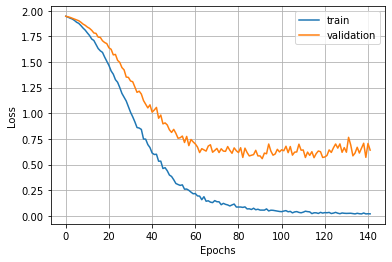

In [12]:
trace_train, trace_val = train(three_layer_gcn, X, A, labels, idx_train, idx_val)

plt.plot(trace_train, label='train')
plt.plot(trace_val, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [13]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


## 2 - Personalized Propagation of Neural Predictions (35 pt) 

We learned that a GCN comes with several limitations. Some of them are targeted via (Approximate) Personalized Propagation of Neural Predictions (A)PPNP.

We use the iterative approach
$$𝐻^{(𝑙+1)}= (1−\alpha) \delta_{\text{dropout}} \hat{A} 𝐻^{(𝑙)} + \alpha 𝐻^{(0)}$$
to approximate the personalized page rank. $\alpha$ denotes the restart/teleport probability and $𝐻^{(0)}$ the result (i.e. logits) of a feed forward neural network on the input features $𝐻^{(0)}=f_{\theta}(X)$. Looking at the details of [[Klicpera et al. 2019]](https://arxiv.org/abs/1810.05997) we understand that dropout is applied to the approximate propagation step (see upcoming Section 2.2). In each step, a randomly drawn dropout mask $\delta_{\text{dropout}}$ is multiplied with the normalized adjacency matrix $\hat{A} = 𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}}$.
 
### 2.1 - Sparse Dropout (10 pt)

Unfortunately, PyTorch's dropout does not work on sparse matrices. However, we simply need to apply dropout to the values of the sparse matrix and then construct the sparse matrix again (`torch.sparse.FloatTensor(...)`).

In [13]:
def sparse_dropout(A: torch.sparse.FloatTensor, p: float, training: bool) -> torch.sparse.FloatTensor:
    ##########################################################
    # YOUR CODE HERE
    
    indices = A.coalesce()._indices()
    values = A.coalesce()._values()
    A_with_dropout = F.dropout(values, p, training)
    A = torch.sparse.FloatTensor(indices, A_with_dropout, A.shape)
    
    ##########################################################
    return A

### 2.2 - Approximate Personalized Pagerank (15 pt)

Implementation of the power iteration for approximating the personalized page rank.

In [14]:
class PowerIterationPageRank(nn.Module):
    """
    Power itertaion module for propagating the labels.
    
    Parameters
    ----------
    dropout: float
        The dropout probability.
    alpha: float
        The teleport probability.
    n_propagation: int
        The number of iterations for approximating the personalized page rank.
    """
    
    def __init__(self,
                 dropout: float = 0.5,
                 alpha: float = 0.15,
                 n_propagation: int = 5):
        super().__init__()
        self.dropout = dropout
        self.alpha = alpha
        self.n_propagation = n_propagation
        
    def forward(self, logits: torch.Tensor, A_hat: torch.sparse.FloatTensor) -> torch.tensor:
        """
        Forward method.
        
        Parameters
        ----------
        logits: torch.tensor
            The local logits (for each node).
        A_hat: torch.tensor
            The normalized adjacency matrix `A_hat`.
            
        Returns
        ---------
        logits: torch.tensor
            The propagated/smoothed logits.
        """
        ##########################################################
        # YOUR CODE HERE
        
        A_dropout = sparse_dropout(A_hat, self.dropout, training=False)
        
        for i in range(self.n_propagation):
             logits = (1 - self.alpha) * A_dropout @ logits + self.alpha * logits           
            
        ##########################################################
        return logits

### 2.3 - Approximate Personalized Propagation of Neural Predictions (10 pt)

Putting it all together (note that you may use `self._normalize(...)`).

In [15]:
class APPNP(GCN):
    """
    Approximate Personalized Propagation of Neural Predictions: as proposed in [Klicpera et al. 2019](https://arxiv.org/abs/1810.05997).
    
    Parameters
    ----------
    n_features: int
        Dimensionality of input features.
    n_classes: int
        Number of classes for the semi-supervised node classification.
    hidden_dimensions: List[int]
        Internal number of features. `len(hidden_dimensions)` defines the number of hidden representations.
    activation: nn.Module
        The activation for each layer but the last.
    dropout: float
        The dropout probability.
    """
    
    def __init__(self,
                 n_features: int,
                 n_classes: int,
                 hidden_dimensions: List[int] = [80],
                 activation: nn.Module = nn.ReLU(),
                 dropout: float = 0.5,
                 alpha: float = 0.1,
                 n_propagation: int = 5):
        super().__init__(n_features, n_classes)
        self.n_features = n_features
        self.n_classes = n_classes
        self.hidden_dimensions = hidden_dimensions
        self.dropout = dropout
        self._transform_features = nn.Sequential(OrderedDict([
            (f'dropout_{0}', nn.Dropout(p=self.dropout))
        ] + list(chain(*[
            [(f'linear_{idx}', nn.Linear(in_features=in_features, out_features=out_features)),
             (f'activation_{idx}', activation)]
            for idx, (in_features, out_features)
            in enumerate(zip([n_features] + hidden_dimensions[:-1], hidden_dimensions))
        ])) + [
            (f'linear_{len(hidden_dimensions)}', nn.Linear(in_features=hidden_dimensions[-1],
                                                        out_features=n_classes)),
            (f'dropout_{len(hidden_dimensions)}', nn.Dropout(p=self.dropout)),
        ]))
        self._propagate = PowerIterationPageRank(dropout=dropout, 
                                                 alpha=alpha, 
                                                 n_propagation=n_propagation)

    def forward(self, X: torch.Tensor, A: torch.sparse.FloatTensor) -> torch.tensor:
        """
        Forward method.
        
        Parameters
        ----------
        X: torch.tensor
            Feature matrix `X`
        A: torch.tensor
            adjacency matrix `A` (with self-loops)
            
        Returns
        ---------
        logits: torch.tensor
            The propagated logits.
        """
        ##########################################################
        # YOUR CODE HERE
        
        A_normalized = self._normalize(A) # normalized adjacency marix
        transformed_features = self._transform_features(X) # transformation
        logits = self._propagate(transformed_features, A_normalized) # propagation
                
        ##########################################################
        return logits

In [16]:
three_layer_appnp = APPNP(n_features=D, n_classes=C, hidden_dimensions=[80, 80])
if use_cuda:
    three_layer_appnp = three_layer_appnp.cuda()
    
three_layer_appnp

APPNP(
  (_layers): ModuleList(
    (0): Sequential(
      (gcn_0): GraphConvolution(
        (_linear): Linear(in_features=2879, out_features=80, bias=False)
      )
      (activation_0): ReLU()
      (dropout_0): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (gcn_1): GraphConvolution(
        (_linear): Linear(in_features=80, out_features=7, bias=False)
      )
    )
  )
  (_transform_features): Sequential(
    (dropout_0): Dropout(p=0.5, inplace=False)
    (linear_0): Linear(in_features=2879, out_features=80, bias=True)
    (activation_0): ReLU()
    (linear_1): Linear(in_features=80, out_features=80, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=80, out_features=7, bias=True)
    (dropout_2): Dropout(p=0.5, inplace=False)
  )
  (_propagate): PowerIterationPageRank()
)

Epoch    0: loss_train: 1.93570, loss_val: 1.93864 
Epoch   10: loss_train: 1.79970, loss_val: 1.84699 
Epoch   20: loss_train: 1.52687, loss_val: 1.64723 
Epoch   30: loss_train: 1.15872, loss_val: 1.37682 
Epoch   40: loss_train: 0.83299, loss_val: 1.11078 
Epoch   50: loss_train: 0.48228, loss_val: 0.88104 
Epoch   60: loss_train: 0.35004, loss_val: 0.73225 
Epoch   70: loss_train: 0.23704, loss_val: 0.63405 
Epoch   80: loss_train: 0.19161, loss_val: 0.61547 
Epoch   90: loss_train: 0.15413, loss_val: 0.61049 
Epoch  100: loss_train: 0.12734, loss_val: 0.65855 
Epoch  110: loss_train: 0.10804, loss_val: 0.68847 
Epoch  120: loss_train: 0.09427, loss_val: 0.79220 
Epoch  130: loss_train: 0.08288, loss_val: 0.61995 
Epoch  140: loss_train: 0.05873, loss_val: 0.64354 
Epoch  150: loss_train: 0.06209, loss_val: 0.72486 
Epoch  160: loss_train: 0.06121, loss_val: 0.81409 



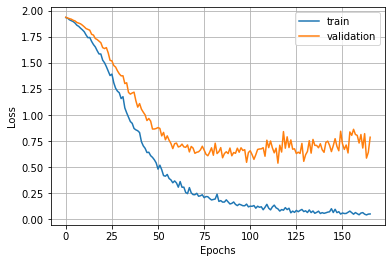

In [17]:
trace_train, trace_val = train(three_layer_appnp, X, A, labels, idx_train, idx_val)

plt.plot(trace_train, label='train')
plt.plot(trace_val, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## 3 - Oversmoothing (10 pt)
As we have learned, we should limit the number of message passing steps for a vanilla GCN to prevent oversmoothing. In this section, we are going to analyze this phenomenon via plotting the test accuracy over the number of propagation steps.

## 3.1 - Accuracy (5 pt)
Please note that you are given the logits (no softmax applied), the labels, and the indices of the test nodes.

In [19]:
def calc_accuracy(logits: torch.Tensor, labels: torch.Tensor, idx_test: np.ndarray) -> float:
    """
    Calculates the accuracy.
    
    Parameters
    ----------
    logits: torch.tensor
        The predicted logits.
    labels: torch.tensor
        The labels vector.
    idx_test: torch.tensor
        The indices of the test nodes.
    """
    ##########################################################
    # YOUR CODE HERE
    predicted_output = logits[idx_test]
    ground_truth = labels[idx_test]
    accuracy = (np.count_nonzero(torch.argmax(predicted_output, dim=-1).cpu().detach().numpy()
                                 == ground_truth.cpu().detach().numpy()) / len(logits))
    ##########################################################
    return accuracy

## 3.2 - Compare GCN and APPNP (5 pt)

Calculate the accuracy (keep in mind that dropout is only applied during training). Subsequently, we plot the accuracies over the numer of propagation steps.

In [20]:
n_hidden_dimensions = 80
n_propagations = [1,2,3,4,5,10]

test_accuracy_gcn = []
for n_propagation in n_propagations:
    model = GCN(n_features=D, n_classes=C, hidden_dimensions=n_propagation*[n_hidden_dimensions])
    if use_cuda:
        model = model.cuda()
    train(model, X, A, labels, idx_train, idx_val, display_step=-1)
    ##########################################################
    # YOUR CODE HERE
    model.dropout = 0
    accuracy = calc_accuracy(model(X, A), labels, idx_test)
    ##########################################################
    test_accuracy_gcn.append(accuracy)
    
test_accuracy_appnp = []
for n_propagation in n_propagations:
    model = APPNP(n_features=D, n_classes=C, n_propagation=n_propagation)
    if use_cuda:
        model = model.cuda()
    train(model, X, A, labels, idx_train, idx_val, display_step=-1)
    ##########################################################
    # YOUR CODE HERE
    model.dropout = 0
    accuracy = calc_accuracy(model(X, A), labels, idx_test)
    ##########################################################
    test_accuracy_appnp.append(accuracy)

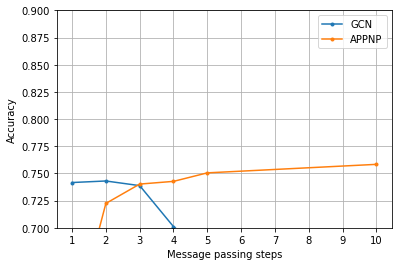

In [21]:
plt.plot(n_propagations, test_accuracy_gcn, label='GCN', marker='.')
plt.plot(n_propagations, test_accuracy_appnp, label='APPNP', marker='.')
plt.xlabel('Message passing steps')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.9)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend()
plt.grid(True)